## File descriptions

    train.csv - the training set
    test.csv - the test set
    sampleSubmission.csv - a sample submission file in the correct format

## Data fields

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры 

In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lr
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

In [3]:
lr = LinearRegression()

In [4]:
ORIGINAL_DATASET_PATH = './data/train.csv' # Оригинальный датасет для обучения
PREPARED_DATASET_PATH = './data/prep_train.csv' # Очищенный датасет
TEST_DATASET_PATH = './data/test.csv' # Данные для проверки модели

In [5]:
orig_df = pd.read_csv(ORIGINAL_DATASET_PATH)
orig_test_df = pd.read_csv(TEST_DATASET_PATH)
X = orig_df.drop('Price', axis=1)
y = orig_df[['Price']]
X_final = pd.read_csv(TEST_DATASET_PATH)
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()
X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

In [6]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [7]:
# orig_df.head(10)

In [8]:
# orig_test_df.describe()

In [9]:
# X[X['KitchenSquare']>100]

In [10]:
# X[X['Rooms']==3.0].mean()

In [11]:
# orig_test_df.head(20)

X['Old_Square'] = X['Square']
X['Old_LifeSquare'] = X['LifeSquare']
X['Old_Square_summ'] = X['Old_Square']-X['Old_LifeSquare']-X['KitchenSquare']

X.loc[X['Old_Square_summ']<0,('LifeSquare','Square')]

X.loc[((X['Square']-X['LifeSquare'])<0),'Square'] = X['Old_LifeSquare']
X.loc[((X['Square']-X['LifeSquare'])<0),'LifeSquare'] = X['Old_Square']


X[X['Old_Square_summ']<0]

X['Square_summ'] = X['Square']-X['LifeSquare']

X[X['Square_summ']<1]

orig_df['Square'].value_counts()

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
class FeatureClear:
    
    def __init__(self):
        self.medians=None
        self.modas=None
        
    def fit(self, X):
        self.medians = X.median()
        self.modas = X.mode().head(1).iloc[0]
    
    def transform(self, X):
        
        X['Correction_count'] = 0
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[X['Rooms_outlier']==1, 'Correction_count'] = X['Correction_count'] + 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.modas['Rooms']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 50, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[(X['Floor'] > X['HouseFloor'])|(X['HouseFloor'] == 0), 'Correction_count'] = X['Correction_count'] + 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = self.medians['HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1       
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.modas['HouseYear']
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['Old_Square'] = X['Square']
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        X['Old_LifeSquare'] = X['LifeSquare']
        X['Old_Square_summ'] = X['Old_Square']-X['Old_LifeSquare']
        X.loc[((X['Square']-X['LifeSquare'])<0),'Square'] = X['Old_LifeSquare']
        X.loc[((X['Square']-X['LifeSquare'])<0),'LifeSquare'] = X['Old_Square']
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'].isna())|(X['Old_Square_summ']<0), 'LifeSquare_outlier'] = 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        return X

In [14]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 20]  ## Important
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df) 
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
        if y is not None:
            df['Price'] = y.values
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_meter_in_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец flooar_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X

In [15]:
clearer = FeatureClear()

In [16]:
clearer.fit(X)

In [17]:
X = clearer.transform(X)
X_final = clearer.transform(X_final)

In [18]:
X.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Shops_1,Correction_count,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Old_Square,LifeSquare_nan,Old_LifeSquare,Old_Square_summ,LifeSquare_outlier
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,7887.000000,7887.000000,10000.000000
mean,1.887600,57.223484,40.727374,6.448900,8.812200,12.95910,1984.863800,0.118858,24.687000,5352.157400,...,4.231300,0.183700,0.001200,0.182500,0.000200,56.315775,0.211300,37.199645,18.034615,0.259500
std,0.811438,77.309420,77.609523,3.340854,4.897278,6.44346,18.409979,0.119025,17.532614,4006.799803,...,4.806341,0.388805,0.034622,0.386275,0.014141,21.058732,0.408251,86.241209,84.638864,0.438382
min,1.000000,2.377248,0.370619,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.136859,0.000000,0.370619,-7398.897712,0.000000
25%,1.000000,41.866858,25.279879,3.000000,5.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,41.774881,0.000000,22.769832,13.680048,0.000000
50%,2.000000,52.633651,35.518682,6.000000,8.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,52.513310,0.000000,32.781260,18.464100,0.000000
75%,2.000000,66.004634,48.690336,9.000000,13.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,65.900625,0.000000,45.128803,24.532159,1.000000
max,5.000000,7480.592129,7480.592129,48.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,...,23.000000,2.000000,1.000000,1.000000,1.000000,641.065193,1.000000,7480.592129,125.041526,1.000000


In [19]:
X.dtypes

DistrictId             object
Rooms                 float64
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                 float64
HouseFloor            float64
HouseYear             float64
Ecology_1             float64
Ecology_2              object
Ecology_3              object
Social_1                int64
Social_2                int64
Social_3                int64
Helthcare_2             int64
Shops_1                 int64
Shops_2                object
Correction_count        int64
Rooms_outlier           int64
HouseFloor_outlier      int64
HouseYear_outlier       int64
Old_Square            float64
LifeSquare_nan          int64
Old_LifeSquare        float64
Old_Square_summ       float64
LifeSquare_outlier      int64
dtype: object

In [20]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [21]:
X.head(20)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_nan,Old_LifeSquare,Old_Square_summ,LifeSquare_outlier,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,1,...,0,29.442751,18.538811,0,22.0,0,3.0,3.0,207786.135836,186508.208565
1,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,1,...,0,40.049543,25.634097,0,87.0,0,3.0,3.0,300009.450063,186508.208565
2,53,2.0,44.947953,29.197612,3.0,8.0,12.0,1968.0,0.049637,1,...,0,29.197612,15.750341,0,174.0,0,3.0,3.0,263206.223152,186508.208565
3,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,1,...,0,52.731512,0.621469,0,179.0,0,3.0,3.0,166809.665642,186508.208565
4,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,1,...,0,23.776169,15.873023,0,97.0,0,4.0,3.0,158539.052715,182431.905609
5,59,3.0,80.384479,46.683720,12.0,5.0,17.0,2011.0,0.309479,1,...,0,46.683720,33.700759,0,67.0,0,2.0,6.0,466753.618497,156389.514464
6,154,2.0,62.254114,37.160377,7.0,3.0,5.0,1960.0,0.460556,1,...,0,37.160377,25.093736,0,5.0,1,2.0,3.0,NaN,182195.527719
7,74,2.0,80.312926,74.312926,3.0,13.0,13.0,1977.0,0.075779,1,...,1,NaN,NaN,1,114.0,0,4.0,3.0,243031.695525,182431.905609
8,1,2.0,64.511437,58.511437,3.0,9.0,17.0,1977.0,0.007122,1,...,1,NaN,NaN,1,652.0,0,3.0,3.0,202666.310126,186508.208565
9,23,1.0,46.461409,18.915552,8.0,13.0,17.0,2014.0,0.075779,1,...,0,18.915552,27.545856,0,565.0,0,4.0,6.0,102069.270740,183213.528975


In [22]:
X.dtypes

DistrictId              object
Rooms                  float64
Square                 float64
LifeSquare             float64
KitchenSquare          float64
Floor                  float64
HouseFloor             float64
HouseYear              float64
Ecology_1              float64
Ecology_2                int64
Ecology_3                int64
Social_1                 int64
Social_2                 int64
Social_3                 int64
Helthcare_2              int64
Shops_1                  int64
Shops_2                  int64
Correction_count         int64
Rooms_outlier            int64
HouseFloor_outlier       int64
HouseYear_outlier        int64
Old_Square             float64
LifeSquare_nan           int64
Old_LifeSquare         float64
Old_Square_summ        float64
LifeSquare_outlier       int64
DistrictId_count       float64
new_district             int64
floor_cat              float64
year_cat               float64
MedPriceByDistrict     float64
MedPriceByFloorYear    float64
dtype: o

In [23]:


# Удаляю, просто чтобы было быстрее строить модель. Возможно, вам стоит что-то сделать с не количественными признаками
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
                   'HouseFloor', 'HouseYear',
                   
                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear','Correction_count']

X = X[remain_features]
X_final  = X_final[remain_features]

lgb_model = LGBMRegressor(criterion='mse',
                            #min_samples_leaf=10,
                            random_state=42 #,
                         
                         # n_estimators=100,
                         # max_depth=7 
                         )

params = {'n_estimators':[200,250,300,350], 
          'max_depth':np.arange(2,12),
          'min_samples_leaf':np.arange(2,12)}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
gs.fit(X, y)

In [24]:
#gs.best_params_

In [44]:
#gs.best_score_
X.dtypes

Rooms                  float64
Square                 float64
LifeSquare             float64
KitchenSquare          float64
Floor                  float64
Ecology_1              float64
Social_1                 int64
Shops_1                  int64
Rooms_outlier            int64
HouseFloor_outlier       int64
HouseYear_outlier        int64
HouseFloor             float64
HouseYear              float64
DistrictId_count       float64
new_district             int64
Ecology_2                int64
Ecology_3                int64
Shops_2                  int64
MedPriceByDistrict     float64
MedPriceByFloorYear    float64
Correction_count         int64
dtype: object

In [26]:
model = LGBMRegressor(max_depth=9,
                             min_samples_leaf=3,
                             n_estimators=200,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.744 +- 0.020


In [27]:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=9,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=3,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

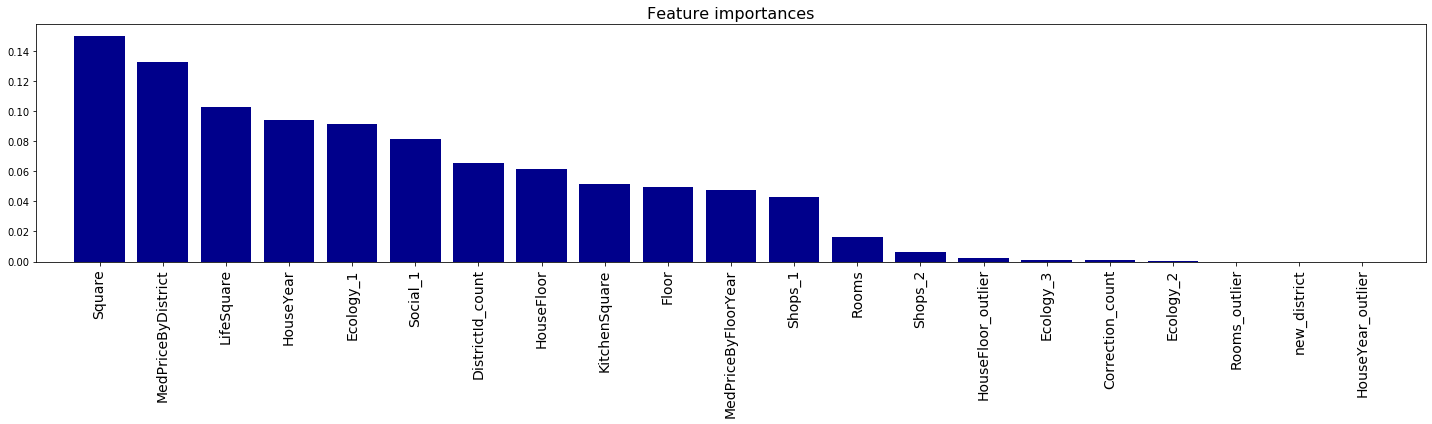

In [28]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [29]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions_lgbm.csv', index=False)

preds_final.head()

,Id,Price
0,725,154541.453415
1,15856,255111.661031
2,5480,146426.725915
3,15664,312005.279478
4,14275,143648.014531


In [30]:
preds_final.shape

(5000, 2)

In [31]:
X[X['Square']<10]

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,Rooms_outlier,HouseFloor_outlier,...,HouseFloor,HouseYear,DistrictId_count,new_district,Ecology_2,Ecology_3,Shops_2,MedPriceByDistrict,MedPriceByFloorYear,Correction_count
1316,1.0,4.633498,1.969969,3.0,13.0,0.011654,4,0,0,1,...,1.0,1977.0,851.0,0,1,1,1,118349.682906,182431.905609,1
1608,1.0,4.604943,4.604943,3.0,3.0,0.243205,5,0,0,0,...,25.0,2014.0,511.0,0,1,1,1,130642.394556,156389.514464,0
3413,1.0,5.549458,5.549458,3.0,1.0,0.150818,16,5,0,0,...,1.0,1977.0,34.0,0,1,1,1,226173.529684,171916.195050,0
4853,1.0,2.377248,0.873147,3.0,1.0,0.017647,2,0,1,1,...,13.0,1977.0,851.0,0,1,1,1,118349.682906,171916.195050,2
4900,3.0,5.610772,5.610772,3.0,8.0,0.211401,9,1,0,0,...,19.0,2016.0,851.0,0,1,1,1,213530.788443,168363.687480,0
6392,1.0,4.525736,4.525736,3.0,13.0,0.007122,1,1,0,1,...,1.0,1977.0,652.0,0,1,1,1,146735.671740,182431.905609,1
8283,1.0,2.642219,2.642219,3.0,13.0,0.069753,53,11,0,1,...,4.0,1977.0,111.0,0,1,1,1,195428.256849,182431.905609,1
9294,1.0,5.257278,5.257278,3.0,13.0,0.195781,23,2,0,1,...,1.0,1977.0,116.0,0,1,1,1,234713.142502,182431.905609,1
9613,1.0,4.618547,4.618547,3.0,13.0,0.060753,15,7,0,1,...,1.0,1977.0,36.0,0,1,1,1,247856.313318,182431.905609,1


In [32]:
orig_test_df[(orig_test_df['Square']<20.0) | (orig_test_df['LifeSquare']<10.0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
18,3495,27,3.0,82.652818,5.690155,1.0,4,17.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A
66,9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
71,9205,120,2.0,85.911827,4.188395,1.0,5,1.0,2016,0.341072,B,B,27,5664,48,2300.0,3,11,B
77,7034,45,2.0,59.927502,3.798341,1.0,23,1.0,2017,0.195781,B,B,23,5212,6,NaN,3,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,8963,27,3.0,79.114387,3.329216,1.0,3,22.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
4846,5002,1,3.0,82.624843,4.379317,1.0,5,17.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B
4863,4611,27,2.0,76.709543,2.989508,1.0,13,12.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A
4902,1420,45,1.0,1.975769,2.900371,1.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B


In [33]:
orig_test_df[orig_test_df['LifeSquare']<10.0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
18,3495,27,3.0,82.652818,5.690155,1.0,4,17.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A
66,9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
71,9205,120,2.0,85.911827,4.188395,1.0,5,1.0,2016,0.341072,B,B,27,5664,48,2300.0,3,11,B
77,7034,45,2.0,59.927502,3.798341,1.0,23,1.0,2017,0.195781,B,B,23,5212,6,NaN,3,2,B
78,6553,34,5.0,122.375273,0.333490,0.0,9,0.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,8963,27,3.0,79.114387,3.329216,1.0,3,22.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
4846,5002,1,3.0,82.624843,4.379317,1.0,5,17.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B
4863,4611,27,2.0,76.709543,2.989508,1.0,13,12.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A
4902,1420,45,1.0,1.975769,2.900371,1.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B


In [34]:
X[(X['Rooms']==2.0) & (X['Square']>100.0)]

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,Rooms_outlier,HouseFloor_outlier,...,HouseFloor,HouseYear,DistrictId_count,new_district,Ecology_2,Ecology_3,Shops_2,MedPriceByDistrict,MedPriceByFloorYear,Correction_count
590,2.0,263.542020,263.542020,5.0,13.0,0.075779,6,2,0,1,...,5.0,1972.0,565.0,0,1,1,1,142883.014837,182431.905609,1
907,2.0,101.348506,53.867589,14.0,12.0,0.000991,33,9,0,0,...,12.0,2010.0,29.0,0,1,1,1,330909.502980,252437.531157,0
2734,2.0,100.982133,100.982133,10.0,5.0,0.075424,11,0,0,0,...,6.0,2014.0,851.0,0,1,1,1,165683.084779,156389.514464,0
2839,2.0,102.024454,102.024454,3.0,12.0,0.000000,25,1,0,0,...,21.0,2015.0,59.0,0,1,1,1,239840.323247,183213.528975,0
3431,2.0,139.070296,89.787666,42.0,13.0,0.014073,2,0,0,1,...,3.0,2016.0,851.0,0,1,1,1,165683.084779,183213.528975,1
4262,2.0,604.705972,598.705972,3.0,17.0,0.161532,25,4,0,0,...,18.0,1977.0,294.0,0,1,1,1,187787.974511,171323.515653,0
4347,2.0,103.621764,97.621764,3.0,13.0,0.072158,2,0,0,1,...,1.0,1977.0,247.0,0,1,1,0,178912.369081,182431.905609,1
5350,2.0,102.683649,101.525114,3.0,13.0,0.093443,23,4,0,1,...,1.0,1977.0,59.0,0,1,1,1,239840.323247,182431.905609,1
5421,2.0,148.671938,100.201652,3.0,1.0,0.014073,2,0,0,0,...,3.0,2013.0,565.0,0,1,1,1,142883.014837,155536.339047,0
5494,2.0,106.427686,34.230415,32.0,4.0,0.151346,32,1,0,0,...,40.0,2013.0,55.0,0,1,0,1,339414.550019,156389.514464,0


In [35]:
X_num_features = X.select_dtypes(include=['float64','int64'])
# X_num_features.drop('median_house_value', axis=1, inplace=True)

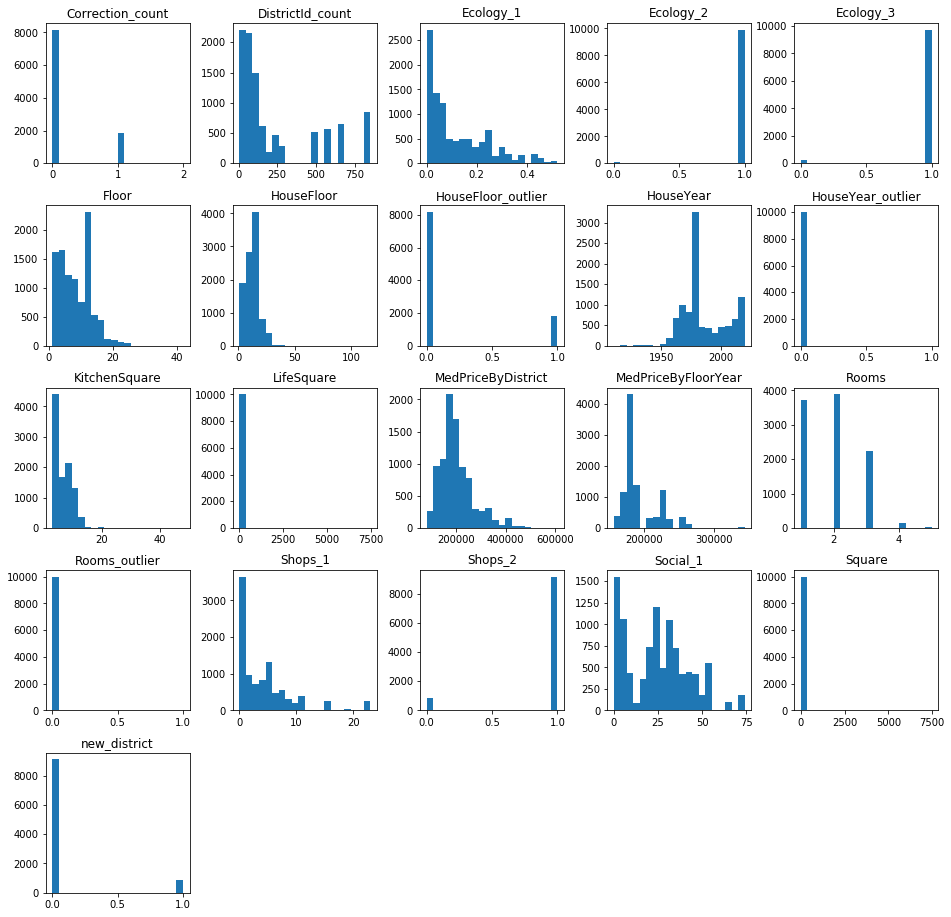

In [36]:
X_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [37]:
X.dtypes

Rooms                  float64
Square                 float64
LifeSquare             float64
KitchenSquare          float64
Floor                  float64
Ecology_1              float64
Social_1                 int64
Shops_1                  int64
Rooms_outlier            int64
HouseFloor_outlier       int64
HouseYear_outlier        int64
HouseFloor             float64
HouseYear              float64
DistrictId_count       float64
new_district             int64
Ecology_2                int64
Ecology_3                int64
Shops_2                  int64
MedPriceByDistrict     float64
MedPriceByFloorYear    float64
Correction_count         int64
dtype: object

In [38]:
X[X['Rooms'] >= 6]

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,Rooms_outlier,HouseFloor_outlier,...,HouseFloor,HouseYear,DistrictId_count,new_district,Ecology_2,Ecology_3,Shops_2,MedPriceByDistrict,MedPriceByFloorYear,Correction_count


In [39]:
ololo = X['Rooms'].mode()

In [40]:
ololo

0    2.0
dtype: float64

In [41]:
X.median()

Rooms                       2.000000
Square                     52.633651
LifeSquare                 35.518682
KitchenSquare               6.000000
Floor                       8.000000
Ecology_1                   0.075424
Social_1                   25.000000
Shops_1                     3.000000
Rooms_outlier               0.000000
HouseFloor_outlier          0.000000
HouseYear_outlier           0.000000
HouseFloor                 13.000000
HouseYear                1977.000000
DistrictId_count          104.000000
new_district                0.000000
Ecology_2                   1.000000
Ecology_3                   1.000000
Shops_2                     1.000000
MedPriceByDistrict     187966.419078
MedPriceByFloorYear    182431.905609
Correction_count            0.000000
dtype: float64

In [42]:
X.mode().head(1).iloc[0]

Rooms                       2.000000
Square                      2.377248
LifeSquare                  0.370619
KitchenSquare               3.000000
Floor                      13.000000
Ecology_1                   0.007122
Social_1                    2.000000
Shops_1                     0.000000
Rooms_outlier               0.000000
HouseFloor_outlier          0.000000
HouseYear_outlier           0.000000
HouseFloor                 17.000000
HouseYear                1977.000000
DistrictId_count            5.000000
new_district                0.000000
Ecology_2                   1.000000
Ecology_3                   1.000000
Shops_2                     1.000000
MedPriceByDistrict     118349.682906
MedPriceByFloorYear    182431.905609
Correction_count            0.000000
Name: 0, dtype: float64